### this script sets a baseline for relation extraction using frequency-based BOW model

#### add additional features

In [1]:
import gzip
import numpy as np
import random
import os
import json

from collections import Counter, defaultdict, namedtuple
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import FunctionTransformer,LabelEncoder
import numpy as np
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
# import networkx as nx
import spacy
nlp = spacy.load('en')

In [18]:
##################################################################################################
# 1. LOAD DATA ALTERED
##################################################################################################

PairExample = namedtuple('PairExample',
    'entity_1, entity_2, snippet')
Snippet = namedtuple('Snippet',
    'left, mention_1, middle, mention_2, right, direction')
def load_data(file, verbose=True):
    f = open(file,'r', encoding='utf-8')
    data = []
    labels = []
    for i,line in enumerate(f):
        instance = json.loads(line)

        instance_tuple = PairExample(instance['entity_1'],instance['entity_2'],[])
        
        for snippet in instance['snippet']:
            try:
                snippet_tuple = Snippet(snippet['left'],snippet['mention_1'],snippet['middle'],
                                   snippet['mention_2'],snippet['right'],
                                    snippet['direction'])
                instance_tuple.snippet.append(snippet_tuple)
                
                data.append(instance_tuple)
                labels.append(instance['relation'])
                instance_tuple = PairExample(instance['entity_1'],instance['entity_2'],[])
                
            except:
                print(instance)


    return data,labels
    
train_data, train_labels = load_data('data/train.json.txt')

In [19]:
# Statistics over relations
def print_stats(labels):
    labels_counts = Counter(labels)
    print('{:20s} {:>10s} {:>10s}'.format('', '', 'rel_examples'))
    print('{:20s} {:>10s} {:>10s}'.format('relation', 'examples', '/all_examples'))
    print('{:20s} {:>10s} {:>10s}'.format('--------', '--------', '-------'))
    for k,v in labels_counts.items():
        print('{:20s} {:10d} {:10.2f}'.format(k, v, v /len(labels)))
    print('{:20s} {:>10s} {:>10s}'.format('--------', '--------', '-------'))
    print('{:20s} {:10d} {:10.2f}'.format('Total', len(labels), len(labels) /len(labels)))

print('Train set statistics:')
print_stats(train_labels)

Train set statistics:
                                rel_examples
relation               examples /all_examples
--------               --------    -------
author                    13113       0.31
worked_at                  3669       0.09
NO_REL                     3068       0.07
has_spouse                13061       0.31
capital                    9427       0.22
--------               --------    -------
Total                     42338       1.00


In [20]:
## check that each entity pair is assigned only one relation
# pair_dict={}
# rel_dict={}
# for example, label in zip(train_data,train_labels):
#     if (example.entity_1,example.entity_2) not in pair_dict.keys():
#         pair_dict[(example.entity_1,example.entity_2)] = [label]
        
#     else:
#         pair_dict[(example.entity_1,example.entity_2)].append(label)
# #         print(example.entity_1,example.entity_2,label)
#     if label not in rel_dict.keys():
#         rel_dict[label] = [example]
#     else:
#         rel_dict[label].append(example)
# print("Done building dictionary")  
    
# # example for each relation
# for rel in rel_dict.keys():
#     ex = rel_dict[rel][0]
#     print(rel,ex.entity_1,ex.entity_2)

In [21]:
def SelectContext(data, verbose=True):
    """BOW feature extraction"""
    only_context_data = []
    for instance in data:
        
        instance_context = []
        for s in instance.snippet:
            context = s.left + " m_1 " + s.middle + " m_2 " + s.right
            instance_context.append(context)
        only_context_data.append(' '.join(instance_context))
    if verbose:
        print(len(only_context_data))
        print(only_context_data[0])
        print(only_context_data[0])
    return only_context_data

In [22]:
# test_feat = SelectContext(train_data[:200])

In [23]:
def ExractSimpleFeatures(data, verbose=True):
    """Considers length and words of middle segment"""
    featurized_data = []
    for instance in data:
        featurized_instance = {'mid_words': '', 'distance': np.inf}
        for s in instance.snippet:
            if len(s.middle.split()) < featurized_instance['distance']:
                featurized_instance['mid_words'] = s.middle
                featurized_instance['distance'] = len(s.middle.split())
        featurized_data.append(featurized_instance)
    if verbose:
        print(len(featurized_data))
        print(featurized_data[0])
        print(featurized_data[1])
    return featurized_data

In [24]:
# test_feat = ExractSimpleFeatures(train_data[:200])

In [25]:
def LengthOfEntities(data, verbose=True):
    featurized_data = []
    for instance in data:
        featurized_instance = {
            'entity1_len': len(instance.entity_1.split("_")),
            'entity2_len': len(instance.entity_2.split("_")),
            'combined_len': len(instance.entity_1.split("_")) + len(instance.entity_2.split("_"))
        }
        featurized_data.append(featurized_instance)
    if verbose:
        print(len(featurized_data))
        print(featurized_data[0])
        print(featurized_data[1])
    return featurized_data 

In [26]:
# test_feat = LengthOfEntities(train_data[:200])

In [27]:
def UseNLP(data, verbose=True):
    """
    Processes each data instance with Spacy's nlp pipeline 
    and collects POS tags for context window around mentions
    as well as length of dependency path between two mentions
    """
    featurized_data = []

    for instance in data:
        featurized_instance = {'tagged_context_1': '', 'tagged_context_2': '', 'path_length': 0}

        for s in instance.snippet:
            
            context = s.left + " m_1 " + s.middle + " m_2 " + s.right
            
            document = nlp(context) # spacy pipeline
            
            tagged_context_1 = []
            tagged_context_2 = []
            
            for i, w in enumerate(document):
                if w.orth_ == "m_1":
                    window_1 = document[i-3:i+4]
                    for e in window_1:
                        if e.orth_ == "m_1" or e.orth_ == "m_2":
                            tagged_context_1.append("MENTION")
                        else:
                            tagged_context_1.append(e.pos_)
                
                if w.orth_ == "m_2":
                    window_2 = document[i-3:i+4]
                    if window_2:
                        for e in window_2:
                            if e.orth_ == "m_1" or e.orth_ == "m_2":
                                tagged_context_2.append("MENTION")
                            else:
                                tagged_context_2.append(e.pos_)
            
            featurized_instance['tagged_context_1'] = ' '.join(tagged_context_1)
            featurized_instance['tagged_context_2'] = ' '.join(tagged_context_2)
            
            edges = []
            for w in document: # FYI https://spacy.io/docs/api/token
                for child in w.children:
                    edges.append(('{0}-{1}'.format(w.lower_, w.i),
                                  '{0}-{1}'.format(child.lower_, child.i)))

            graph = nx.Graph(edges)
            for w in graph:
                if "m_1" in w:
                    s = w
                if "m_2" in w:
                    t = w
            
            try:
                featurized_instance['path_length'] = nx.shortest_path_length(graph, source=s, target=t)
            except nx.NetworkXNoPath: # unrelated?
                featurized_instance['path_length'] = 0
            except nx.NodeNotFound: # problem with mention
                featurized_instance['path_length'] = 0.5

        featurized_data.append(featurized_instance)
        
        if len(featurized_data)%5000 == 0:
            print("{} instances processed for nlp.".format(len(featurized_data)))
                
    if verbose:
        print(len(featurized_data))
        print(featurized_data[0])
        print(featurized_data[1])
            
    return featurized_data

In [28]:
# test_feat = UseNLP(train_data[:500])

In [29]:
class SimpleFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, featurizer):
        self.featurizers = featurizer

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return ExractSimpleFeatures(X, verbose=False)

In [30]:
class EntityLengthFeaturizer(BaseEstimator, TransformerMixin):
    """Extract features from each isntance for DictVectorizer"""
    def __init__(self, featurizer):
        self.featurizers = featurizer
        
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return LengthOfEntities(X, verbose=False)

In [31]:
class BowFeaturizer(BaseEstimator, TransformerMixin):
    """BOW featurizer"""
    def __init__(self, featurizer):
        self.featurizers = featurizer
        
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return SelectContext(X, verbose=False)

In [32]:
class DependencyPath(BaseEstimator, TransformerMixin):
    """Considers pos tags of window around mentions and length of dependency path between mentions"""
    def __init__(self, featurizer):
        self.featurizers = featurizer
        
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # Applies spacy's nlp pipeline to data. Status indicates how many instances have been processed.
        return UseNLP(X, verbose=False)

In [33]:
# Transform labels to numeric values
le = LabelEncoder()
train_labels_featurized = le.fit_transform(train_labels)

length_pipe = make_pipeline(EntityLengthFeaturizer(LengthOfEntities), DictVectorizer())

bow_pipe = make_pipeline(BowFeaturizer(SelectContext), CountVectorizer(ngram_range=(1,3)))

simple_pipe = make_pipeline(SimpleFeaturizer(ExractSimpleFeatures), DictVectorizer())

# syntax_pipe = make_pipeline(DependencyPath(UseNLP), DictVectorizer())

def build_classifier(syntactic_features=False):
    if syntactic_features == True:
        clf = make_pipeline(FeatureUnion(transformer_list=[
            ('length_pipeline', length_pipe),
            ('bow_pipeline', bow_pipe),
            ('simple_pipeline', simple_pipe),
            ('syntax_pipeline', syntax_pipe)]),
            LogisticRegression())
    
    else:
        # Without syntactic features
        clf = make_pipeline(FeatureUnion(transformer_list=[
            ('length_pipeline', length_pipe),
            ('bow_pipeline', bow_pipe),
            ('simple_pipeline', simple_pipe)]),
            LogisticRegression())
    
    return clf

clf = build_classifier(syntactic_features=False)

In [34]:
##################################################################################################
# 3. TRAIN CLASSIFIER AND EVALUATE (CV)
##################################################################################################

def print_statistics_header():
    print('{:20s} {:>10s} {:>10s} {:>10s} {:>10s}'.format(
        'relation', 'precision', 'recall', 'f-score', 'support'))
    print('{:20s} {:>10s} {:>10s} {:>10s} {:>10s}'.format(
        '-' * 18, '-' * 9, '-' * 9, '-' * 9, '-' * 9))

def print_statistics_row(rel, result):
    print('{:20s} {:10.3f} {:10.3f} {:10.3f} {:10d}'.format(rel, *result))

def print_statistics_footer(avg_result):
    print('{:20s} {:>10s} {:>10s} {:>10s} {:>10s}'.format(
        '-' * 18, '-' * 9, '-' * 9, '-' * 9, '-' * 9))
    print('{:20s} {:10.3f} {:10.3f} {:10.3f} {:10d}'.format('macro-average', *avg_result))

def macro_average_results(results):
    avg_result = [np.average([r[i] for r in results.values()]) for i in range(3)]
    avg_result.append(np.sum([r[3] for r in results.values()]))
    return avg_result

def average_results(results):
    avg_result = [np.average([r[i] for r in results]) for i in range(3)]
    avg_result.append(np.sum([r[3] for r in results]))
    return avg_result
    
def evaluateCV(classifier, label_encoder, X, y, verbose=True):
    """
    classifier: clf - pipeline with CountVevtorizer and Logistic regression
    label_encoder: le - label encoder
    X: train data featurized
    y: train labels featurized
    """
    results = {}
    for rel in le.classes_:
#         print(rel)
        results[rel] = []
    if verbose:
        print_statistics_header()
        kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=0) 
        for train_index, test_index in kfold.split(X, y):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
            y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
            clf.fit(X_train, y_train)
            pred_labels = classifier.predict(X_test)
            stats = precision_recall_fscore_support(y_test, pred_labels, beta=0.5)
            #print(stats)
            for rel in label_encoder.classes_:
                rel_id = label_encoder.transform([rel])[0]
#             print(rel_id,rel)
                stats_rel = [stat[rel_id] for stat in stats]
                results[rel].append(stats_rel)
        for rel in label_encoder.classes_:
            results[rel] = average_results(results[rel])
            if verbose:
                print_statistics_row(rel, results[rel])
    avg_result = macro_average_results(results)
    if verbose:
        print_statistics_footer(avg_result)
    return avg_result[2]  # return f_0.5 score as summary statistic

In [35]:
evaluateCV(clf, le, train_data, train_labels_featurized)

relation              precision     recall    f-score    support
------------------    ---------  ---------  ---------  ---------
NO_REL                    0.778      0.401      0.654       3068
author                    0.932      0.971      0.939      13113
capital                   0.940      0.973      0.946       9427
has_spouse                0.910      0.977      0.923      13061
worked_at                 0.905      0.816      0.886       3669
------------------    ---------  ---------  ---------  ---------
macro-average             0.893      0.828      0.870      42338


0.8696233397953861

In [ ]:
# A check for the average F1 score

f_scorer = make_scorer(fbeta_score, beta=0.5, average='macro')

def evaluateCV_check(classifier, X, y, verbose=True):
    kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=0) 
    scores = cross_val_score(classifier, X, y, cv=kfold, scoring = f_scorer)
    print("\nCross-validation scores (StratifiedKFold): ", scores)
    print("Mean cv score (StratifiedKFold): ", scores.mean())

In [ ]:
evaluateCV_check(clf, train_data, train_labels_featurized)

In [ ]:
##################################################################################################
# 4. TEST PREDICTIONS and ANALYSIS
##################################################################################################

# Fit final model on the full train data
clf.fit(train_data, train_labels_featurized)

# Predict on test set
test_data, test_labels = load_data('../data/test-covered.json.txt', verbose=False)
print(len(test_data))
print(len(test_labels))
# test_data_featurized = SelectContext(test_data, verbose=False)
test_label_predicted = clf.predict(test_data)
print(len(test_label_predicted))
# Deprecation warning explained: https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
test_label_predicted_decoded = le.inverse_transform(test_label_predicted)
print(len(test_label_predicted_decoded))
print(test_label_predicted_decoded[:2])
f = open("outputs/test_labels2.txt", 'w', encoding="utf-8")
for label in test_label_predicted_decoded:
    f.write(label+'\n')

In [ ]:
# # Feature analysis - print N most informative
# # !! Make changes in this function when you change the pipleine!!
# def printNMostInformative(classifier,label_encoder,N):
#     """Prints features with the highest coefficient values, per class"""
#     feature_names = classifier.named_steps['countvectorizer'].get_feature_names()

#     coef = classifier.named_steps['logisticregression'].coef_    
#     print(coef.shape)
#     for rel in label_encoder.classes_:
#         rel_id = label_encoder.transform([rel])[0]
#         coef_rel = coef[rel_id]
#         coefs_with_fns = sorted(zip(coef_rel, feature_names))
#         top_features = coefs_with_fns[-N:]
#         print("\nClass {} best: ".format(rel))
#         for feat in top_features:
#             print(feat)        
        
# print("Top features used to predict: ")
# # show the top features
# printNMostInformative(clf,le,2)

In [ ]:
# Feature analysis - print N most informative
# !! Make changes in this function when you change the pipleine!!
def printNMostInformative(classifier,label_encoder,N):
    """Prints features with the highest coefficient values, per class"""
    feature_names = classifier.named_steps['length_pipeline'].get_feature_names()

    coef = classifier.named_steps['logisticregression'].coef_    
    print(coef.shape)
    for rel in label_encoder.classes_:
        rel_id = label_encoder.transform([rel])[0]
        coef_rel = coef[rel_id]
        coefs_with_fns = sorted(zip(coef_rel, feature_names))
        top_features = coefs_with_fns[-N:]
        print("\nClass {} best: ".format(rel))
        for feat in top_features:
            print(feat)        
        
print("Top features used to predict: ")
# show the top features
printNMostInformative(clf,le,2)

### Evaluation on TEST data

In [36]:
# load test data
PairExample = namedtuple('PairExample',
                         'entity_1, entity_2, snippet')
Snippet = namedtuple('Snippet',
                     'left, mention_1, middle, mention_2, right, direction')

def load_test_data(file, verbose=True):
    f = open(file,'r', encoding='utf-8')
    data = []
    labels = []
    for i, line in enumerate(f):
        instance = json.loads(line)
        if i == 0:
            if verbose:
                print('json example:')
                print(instance)
        # 'relation, entity_1, entity_2, snippet' fileds for each example
        # 'left, mention_1, middle, mention_2, right, direction' for each snippet
        instance_tuple = PairExample(instance['entity_1'], instance['entity_2'], [])
        for snippet in instance['snippet']:
            try:
                snippet_tuple = Snippet(snippet['left'], snippet['mention_1'],
                                        snippet['middle'], 
                                        snippet['mention_2'], snippet['right'],
                                        snippet['direction'])
                instance_tuple.snippet.append(snippet_tuple)
            except:
                print(instance)
        if i == 0:
            if verbose:
                print('\nexample transformed as a named tuple:')
                print(instance_tuple)
        data.append(instance_tuple)
        labels.append(instance['relation'])

    return data, labels

test_data, test_labels = load_test_data('data/test.json.txt', verbose=False)

In [43]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

In [38]:
# Fit final model on the full train data
clf.fit(train_data, train_labels_featurized)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('length_pipeline', Pipeline(memory=None,
     steps=[('entitylengthfeaturizer', EntityLengthFeaturizer(featurizer=None)), ('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [39]:
# Predict on test set
test_labels_featurized = le.transform(test_labels)
test_label_predicted = clf.predict(test_data)

In [64]:
# ON TEST DATA: TO UPLOAD
# Deprecation warning explained: https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
test_label_predicted_decoded = le.inverse_transform(test_label_predicted)
print(test_label_predicted_decoded[:5])
f = open("test_labels.txt", 'w', encoding="utf-8")
for label in test_label_predicted_decoded:
    f.write(label+'\n')

['capital' 'NO_REL' 'worked_at' 'worked_at' 'has_spouse']


/Users/inigma/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [46]:
y_true = test_labels_featurized
labels = list(set(train_labels))

print(classification_report(y_true, test_label_predicted, target_names=labels))

             precision    recall  f1-score   support

    capital       0.00      0.00      0.00         0
     author       0.95      0.93      0.94       663
  worked_at       0.67      0.98      0.79       127
     NO_REL       0.97      0.97      0.97       755
 has_spouse       0.96      0.74      0.84       295

avg / total       0.94      0.92      0.93      1840



/Users/inigma/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [49]:
final_score = f1_score(y_true, test_label_predicted, average='weighted')
print("Labels: ", labels)
print(y_true[:30])
print(test_label_predicted[:30])

print(final_score)
confusion_matrix(y_true, test_label_predicted)

Labels:  ['capital', 'author', 'worked_at', 'NO_REL', 'has_spouse']
[2 4 4 4 3 1 1 3 1 3 3 1 4 3 3 1 3 4 1 1 1 1 1 2 3 3 3 1 4 3]
[2 0 4 4 3 1 1 3 1 4 3 1 4 3 3 1 3 4 1 1 1 4 1 2 3 3 3 1 2 3]
0.9251234656627951


/Users/inigma/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([[  0,   0,   0,   0,   0],
       [  4, 616,  29,  13,   1],
       [  1,   1, 124,   0,   1],
       [  8,   4,   5, 732,   6],
       [  9,  26,  28,  13, 219]])

In [65]:
y_true_decoded = le.inverse_transform(y_true)
#y_pred_decoded = le.inverse_transform(test_label_predicted)
with open("test_labels.txt", "r") as pred_file:
    y_pred_decoded = pred_file.read().strip().split("\n")
        
print(labels)
cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=labels)
cm

/Users/inigma/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['capital', 'author', 'worked_at', 'NO_REL', 'has_spouse']


array([[123,   2,   1,   1,   0],
       [ 28, 619,   1,   3,  12],
       [ 30,  25, 224,   5,  11],
       [  0,   0,   0,   0,   0],
       [  5,   5,   6,   8, 731]])

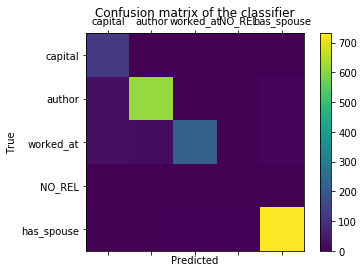

In [66]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/Users/inigma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


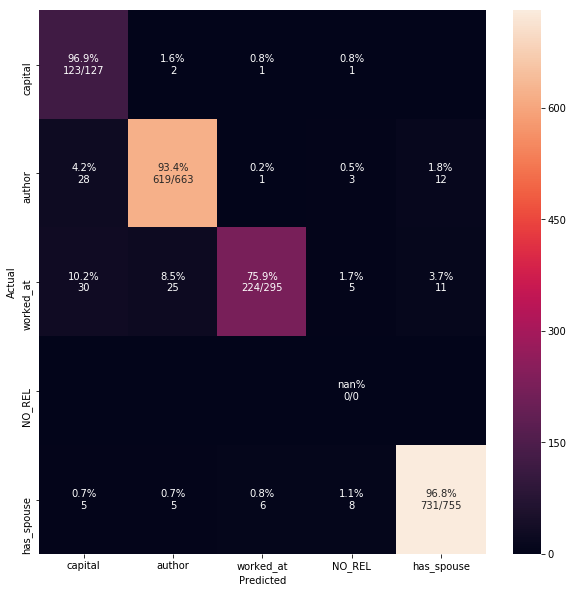

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_true_decoded, y_pred_decoded, labels, ymap=None, figsize=(10,10))